In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

import tensorflow as tf
from tensorflow import keras
from keras import backend as k
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


2024-04-09 03:03:21.658538: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 03:03:21.716694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 03:03:22.786208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
for dirname, _, filenames in os.walk('/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/csv_file
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/114_1b4_Lr_mc_AKGC417L_1.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/135_2b2_Tc_mc_LittC2SE_1.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/147_1b2_Tc_mc_AKGC417L_0.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/207_2b3_Pr_mc_AKGC417L_1.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/154_2b4_Ar_mc_AKGC417L_0.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/172_1b4_Ll_mc_AKGC417L_1.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/218_1b1_Pr_sc_Meditron_3.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/213_1p2_Tc_mc_AKGC417L_0.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/130_1p2_Pl_mc_AKGC417L_1.json
/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/json_file/166_1p1_Al_sc_Meditron_4.json
/home/so

In [3]:
IMAGE_SIZE = 224

In [4]:
img_dir = "/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/png_file" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

We create the variable y containing all the bounding boxe annotations (label). Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that.

In [5]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [6]:
path = '/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file'
text_files = [os.path.join(path, f) for f in sorted(os.listdir(path)) if not f.endswith('.ipynb_checkpoints')]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [7]:
resizeannotation("/home/sogaksa123/AIFFEL_THON/model/Mask_RCNN/dataset/xml_file/104_1b1_Lr_sc_Litt3200_0.xml")

[224, 218, 205, 56]

In [8]:
y[0]

[224, 218, 185, 56]

We check X et y shape

In [9]:
np.array(X).shape

(2978, 224, 224, 3)

In [10]:
np.array(y).shape

(2978, 4)

And we display the first eighteen image of the dataset :

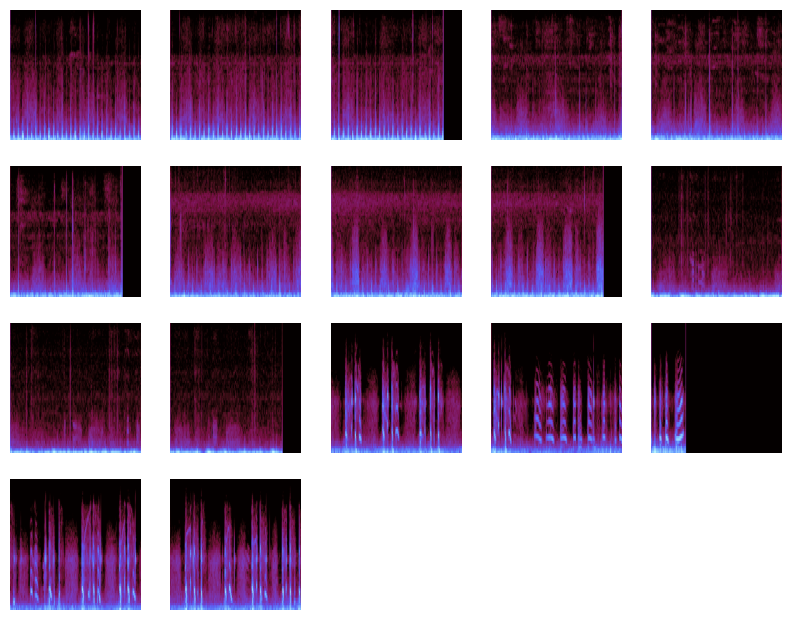

In [11]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

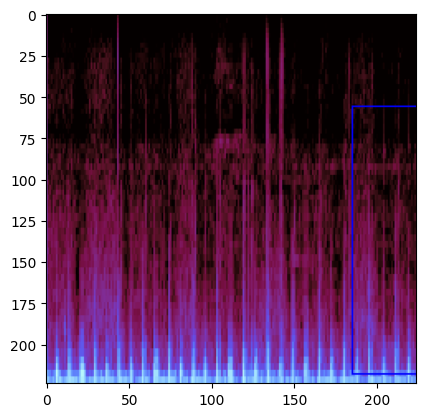

In [12]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

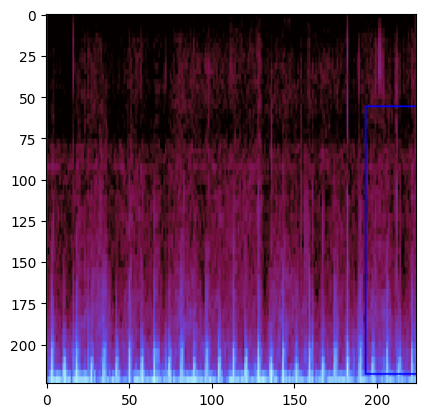

In [13]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [14]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [15]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

###Convolutional Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

In [18]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

2024-04-09 03:03:37.737847: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [20]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32, verbose=1)

Epoch 1/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.3961 - loss: 0.0475 - val_accuracy: 0.4310 - val_loss: 0.0372
Epoch 2/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.4138 - loss: 0.0386 - val_accuracy: 0.4310 - val_loss: 0.0377
Epoch 3/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.4026 - loss: 0.0353 - val_accuracy: 0.4310 - val_loss: 0.0362


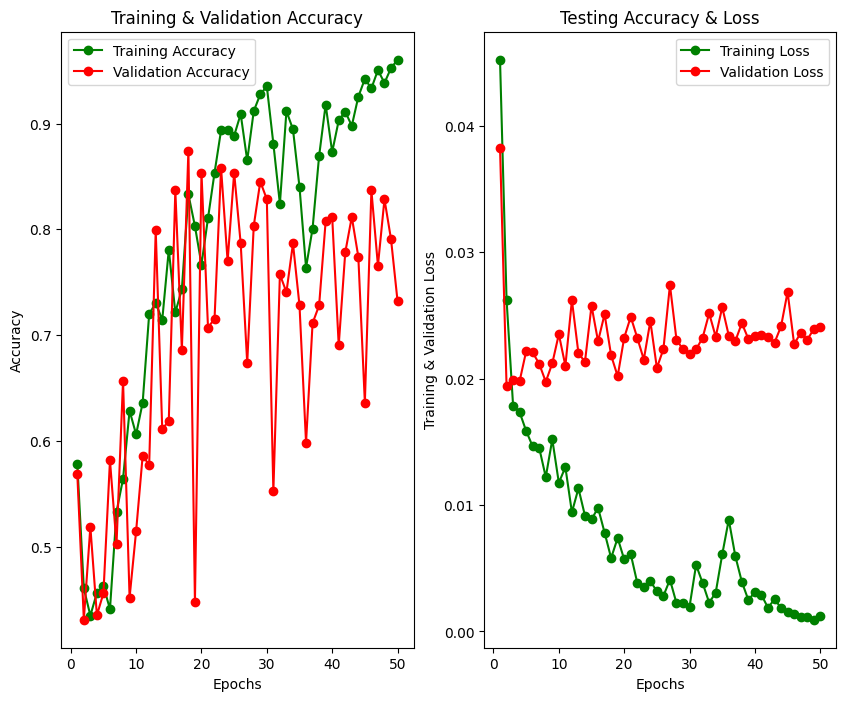

In [46]:
epochs = range(1,51)
fig , ax = plt.subplots(1,2)
train_acc = train.history['accuracy']
train_loss = train.history['loss']
val_acc = train.history['val_accuracy']
val_loss = train.history['val_loss']
fig.set_size_inches(10,8)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
predictions = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

def classwise_metrics(true_labels, predicted_labels, classes):
    metrics_dict = {}
    mlb = MultiLabelBinarizer(classes=classes)

    # 실제 레이블을 이진 형식으로 변환
    true_labels_binary = mlb.fit_transform([[str(label)] for label in true_labels])
    predicted_labels_binary = mlb.transform([[str(label)] for label in predicted_labels])

    # 클래스별 성능 메트릭 계산
    for i, cls in enumerate(classes):
        accuracy = accuracy_score(true_labels_binary[:, i], predicted_labels_binary[:, i])
        precision = precision_score(true_labels_binary[:, i], predicted_labels_binary[:, i])
        recall = recall_score(true_labels_binary[:, i], predicted_labels_binary[:, i])
        f1 = f1_score(true_labels_binary[:, i], predicted_labels_binary[:, i])

        metrics_dict[cls] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

    return metrics_dict

# 클래스 레이블 정의
classes = ['normal', 'crckles', 'wheezes']

# 클래스별 성능 메트릭 계산
metrics_dict = classwise_metrics(y_test, predicted_classes, classes)

# 결과 출력
for cls, metrics in metrics_dict.items():
    print(f"Metrics for class '{cls}':")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}")

Metrics for class 'normal':
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Metrics for class 'crckles':
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Metrics for class 'wheezes':
Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/home/sogaksa123/anaconda3/envs/sogaksa/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['[0.00392157 0.85490196 0.         0.21960784]', '[0.01176471 0.85490196 0.         0.21960784]', '[0.01568627 0.85490196 0.         0.21960784]', '[0.01960784 0.85490196 0.         0.21960784]', '[0.02745098 0.85490196 0.         0.21960784]', '[0.05882353 0.85490196 0.         0.21960784]', '[0.0627451  0.85490196 0.         0.21960784]', '[0.07058824 0.85490196 0.         0.21960784]', '[0.09019608 0.85490196 0.00784314 0.21960784]', '[0.11372549 0.85490196 0.         0.21960784]', '[0.12156863 0.85490196 0.         0.21960784]', '[0.1372549  0.85490196 0.         0.21960784]', '[0.15294118 0.85490196 0.00784314 0.21960784]', '[0.16078431 0.85490196 0.         0.21960784]', '[0.17254902 0.85490196 0.         0.21960784]', '[0.17254902 0.85490196 0.02745098 0.21960784]', '[0.17647059 0.85490196 0.00784314 0.21960784]', '[0.17647059 0.85490196 0.043

In [ ]:
model.save('my_model.h5', overwrite=True) 

In [30]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))
scores

Score : 71.48%


[0.0331917367875576, 0.7147650718688965]

In [25]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

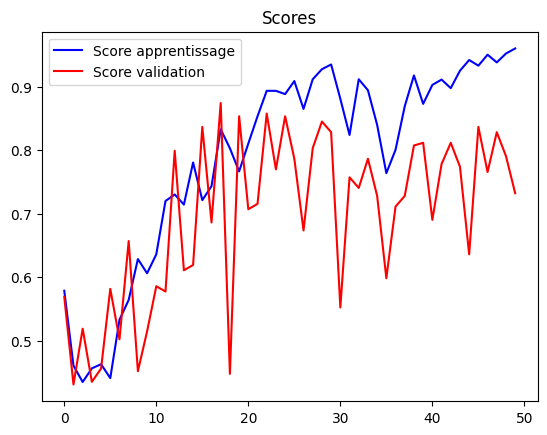

In [26]:
plot_scores(train)

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 352ms/step - accuracy: 0.7377 - loss: 0.0284
Test results 
 Loss: 0.026182835921645164 
 Accuracy 0.7332214713096619


In [28]:
y_cnn = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


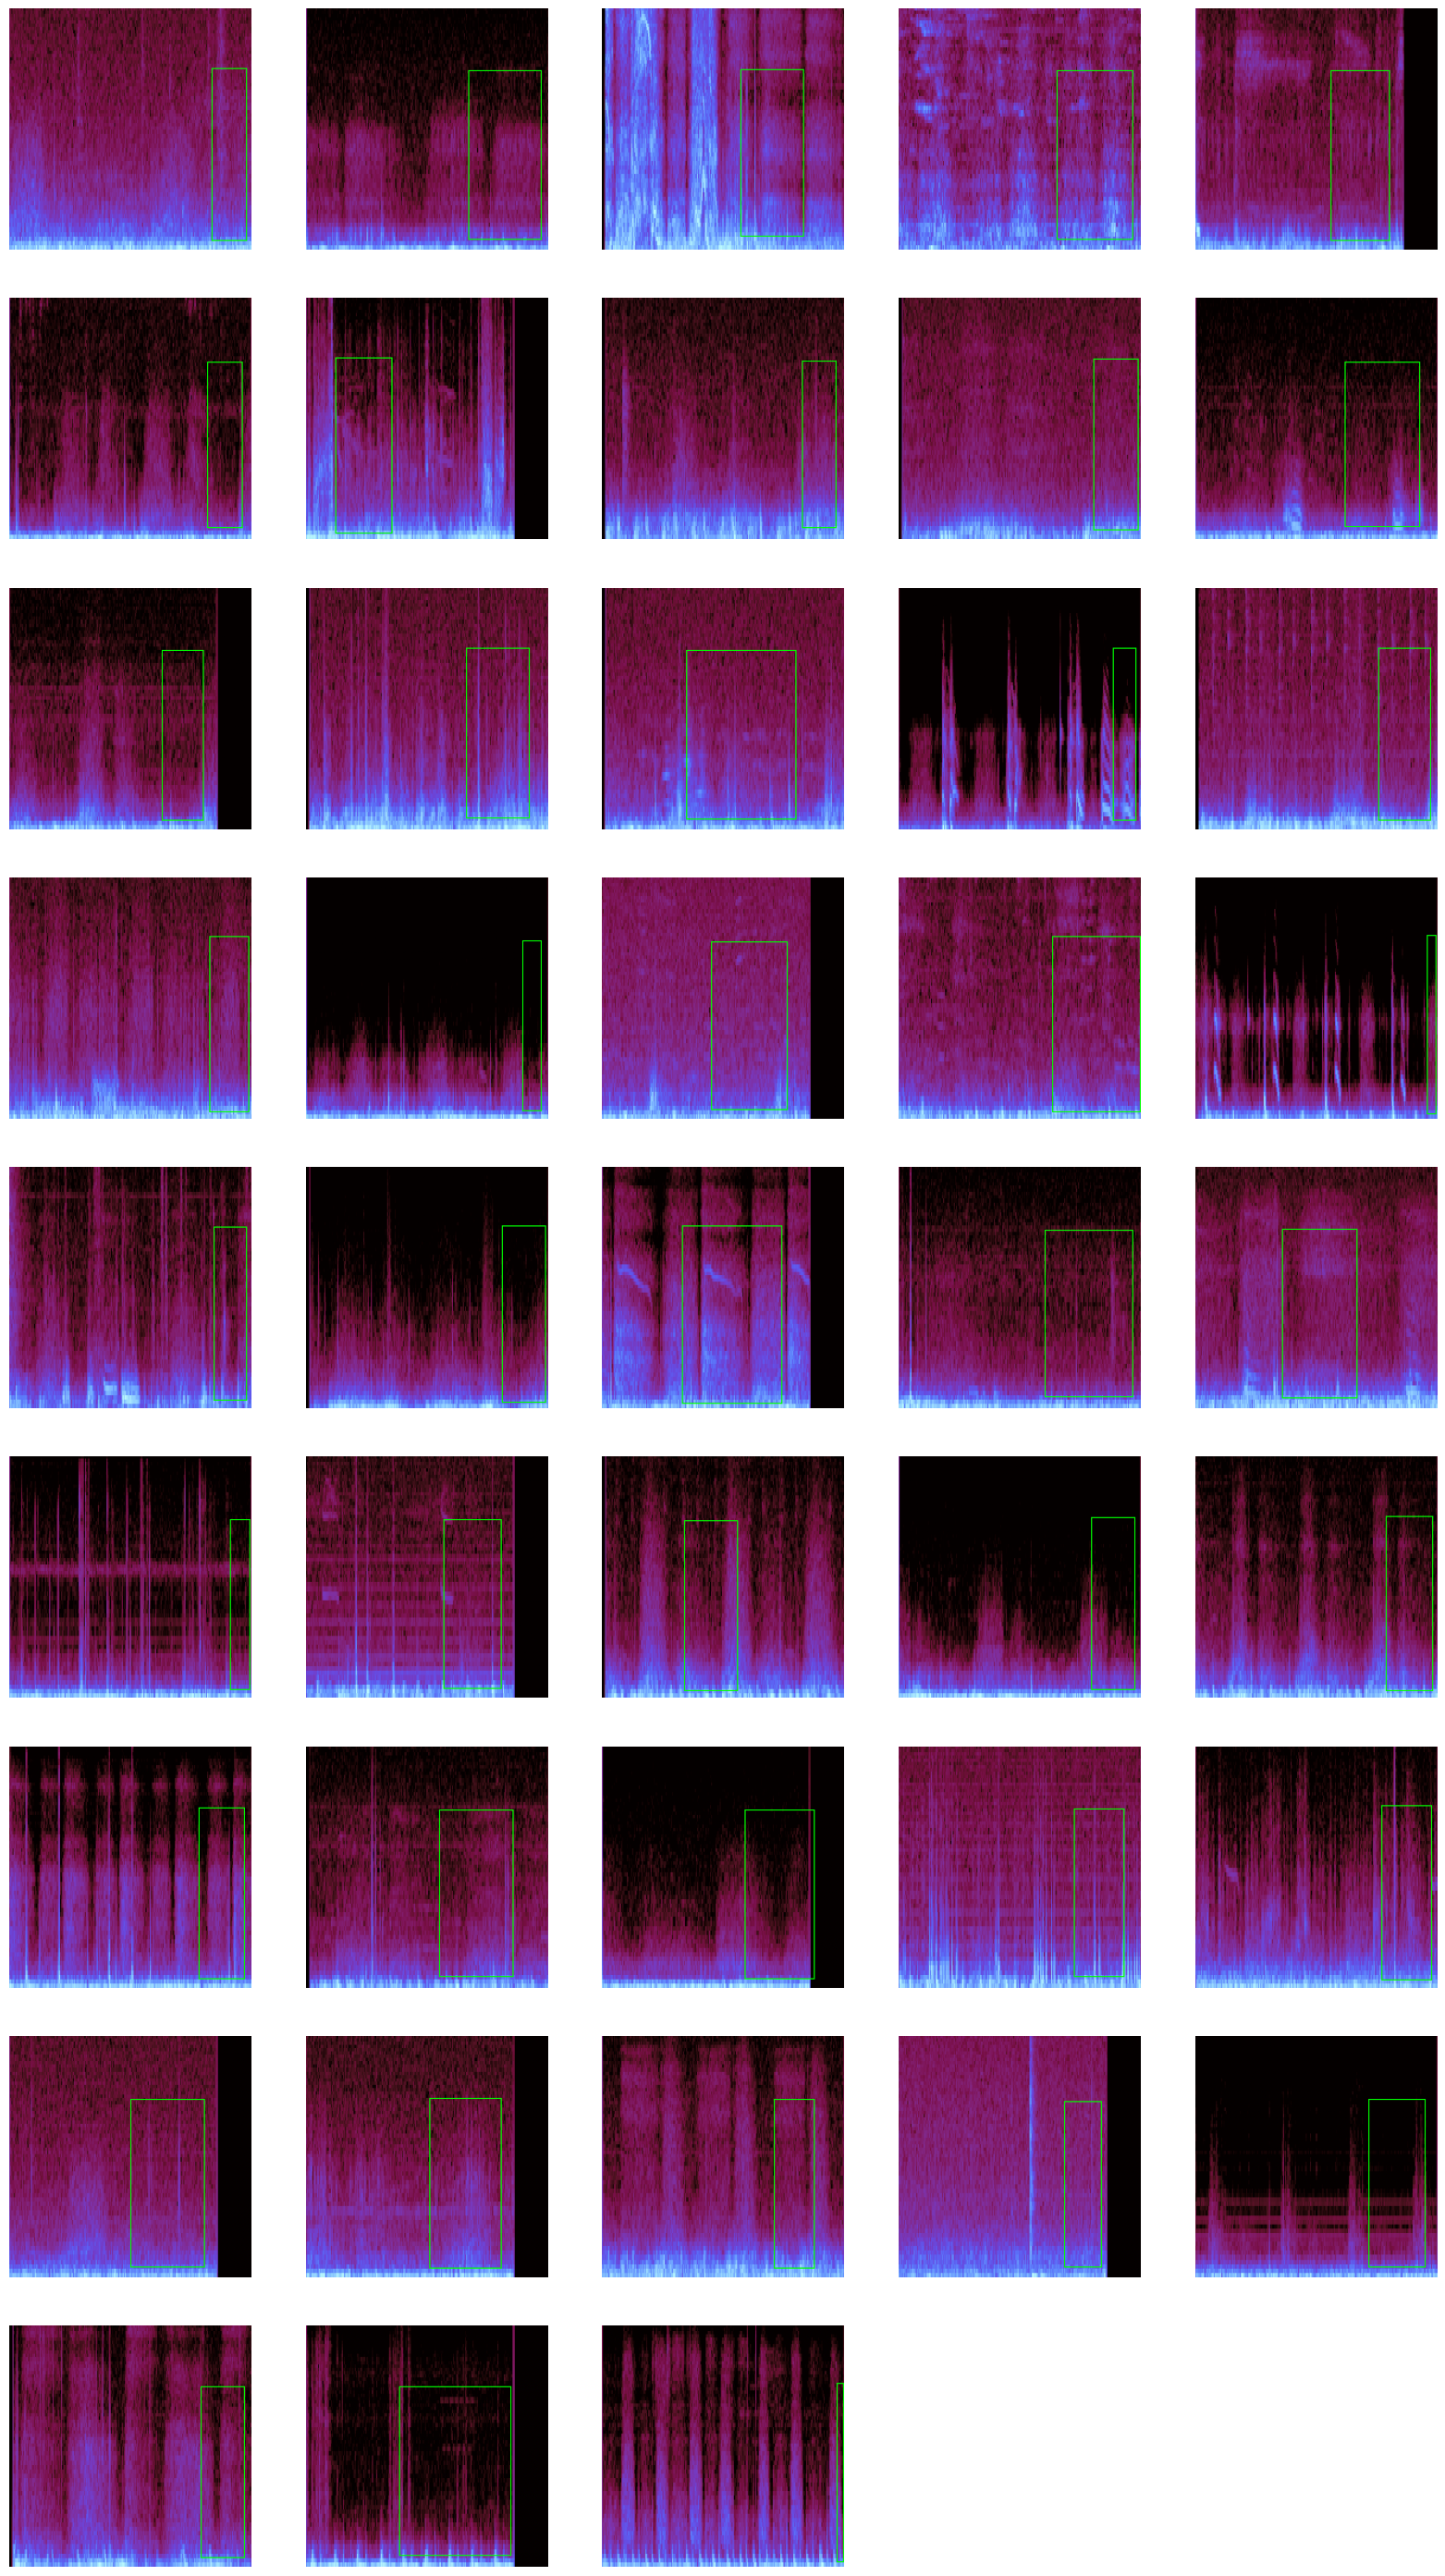

In [29]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

In [1]:
import torch
print(torch.cuda.is_available())

False


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

